In [1]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from numpy.lib.stride_tricks import sliding_window_view
from keras_efficient_kan import KANLinear
import keras
from keras import ops
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Binary classifier model
This section includes the metrics for the binary classifier model

We start by computing the Training and validation datasets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear
from tqdm import tqdm

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36     # 6 hours history
HORIZON = 6       # 6 hour ahead
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.0001

#set the numpy seed to make sure that the unsersampling is reproducible
np.random.seed(42)

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── BUILD WIDE FORMAT ─────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index()
df_pivot = df_pivot.dropna()  


# ── SPLITTING ───────────────────────────────
split1 = int(0.6 * len(df_pivot))
split2 = int(0.8 * len(df_pivot))
df_train = df_pivot.iloc[:split1]
df_val   = df_pivot.iloc[split1:split2]
df_test  = df_pivot.iloc[split2:]

# ── SCALING ───────────────────────────────
scaler = StandardScaler()
data_train = scaler.fit_transform(df_train)
data_val   = scaler.transform(df_val)
data_test  = scaler.transform(df_test)

# ── SAMPLE CONSTRUCTION ───────────────────
# ── SETUP ──────────────────────────────────
precip_cols = [col for col in df_pivot.columns if col.startswith("precip_")]
num_stations = len(precip_cols)

# ── TRAIN SET CONSTRUCTION (undersampled) ─
x_train, y_train = [], []
train_scaled = pd.DataFrame(data_train, columns=df_train.columns, index=df_train.index)

for i in range(HIST_LEN, len(train_scaled) - HORIZON):
    x_window = train_scaled.iloc[i - HIST_LEN:i].values
    horizon_vals = df_train.iloc[i + 1 : i + 1 + HORIZON][precip_cols].values
    y_window = (np.any(horizon_vals > 0, axis=0)).astype(int)
    total_future_rain = np.sum(horizon_vals)

    if total_future_rain == 0 and np.random.rand() > 0.2:
        continue

    x_train.append(x_window)
    y_train.append(y_window)

# ── VALIDATION SET CONSTRUCTION (no undersampling) ─
x_val, y_val = [], []
val_scaled = pd.DataFrame(data_val, columns=df_val.columns, index=df_val.index)

for i in range(HIST_LEN, len(val_scaled) - HORIZON):
    x_window = val_scaled.iloc[i - HIST_LEN:i].values
    horizon_vals = df_val.iloc[i + 1 : i + 1 + HORIZON][precip_cols].values
    y_window = (np.any(horizon_vals > 0, axis=0)).astype(int)

    x_val.append(x_window)
    y_val.append(y_window)

# ── TEST SET CONSTRUCTION (no undersampling) ─
x_test, y_test = [], []
test_scaled = pd.DataFrame(data_test, columns=df_test.columns, index=df_test.index)

for i in range(HIST_LEN, len(test_scaled) - HORIZON):
    x_window = test_scaled.iloc[i - HIST_LEN:i].values
    horizon_vals = df_test.iloc[i + 1 : i + 1 + HORIZON][precip_cols].values
    y_window = (np.any(horizon_vals > 0, axis=0)).astype(int)

    x_test.append(x_window)
    y_test.append(y_window)

# ── CONVERT TO ARRAYS ─────────────────────
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val   = np.array(x_val)
y_val   = np.array(y_val)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

Now we load the model

In [ ]:
model_binary = keras.models.load_model('../model_testing/forecast_binary_6.keras')

We compute the test metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict
y_pred_proba = model_binary.predict(x_test)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Flatten all stations across all samples
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()
y_proba_flat = y_pred_proba.flatten()

# Compute metrics
acc  = accuracy_score(y_true_flat, y_pred_flat)
prec = precision_score(y_true_flat, y_pred_flat)
rec  = recall_score(y_true_flat, y_pred_flat)
f1   = f1_score(y_true_flat, y_pred_flat)
auc  = roc_auc_score(y_true_flat, y_proba_flat)

# Print LaTeX table
print(f'ACC:{acc}, PREcision:{prec}, Recall:{rec}, f1:{f1}, auc:{auc}')


The roc curve and AUC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_flat, y_proba_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("ROC Curve", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/ROC_curve.pdf')
plt.show()

and a confusion matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_flat, y_pred_flat, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 13},
            xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Normalized Confusion Matrix (Test Set)", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/conf_matrix_binary.pdf')
plt.show()

Look at the per station metrics

# Scraps

In [ ]:
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36      # 6 hours history @ 10-minute freq
HORIZON = 6        # predict 1 hour ahead (6 * 10 minutes)
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.001

# ── LOAD & PREP DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")
df = df[df["station"] == "SIO"]

# ── NORMALIZE ────────────────────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
features = df[selected_features]
features.index = df["time"]

train_split = int(SPLIT_FRACTION * len(features))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, index=features.index, columns=selected_features)

x = []
y = []

# ── CREATE SAMPLES ───────────────────────────────
for i in range(HIST_LEN, len(features) - HORIZON):
    x.append(features.iloc[i - HIST_LEN:i].values)
    y.append(features.iloc[i + HORIZON]["precip"])  # forecast rain

x = np.array(x)
y = np.array(y)

split_idx = int(SPLIT_FRACTION * len(x))
x_train, x_val = x[:split_idx], x[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ── PREDICT ───────────────────────────────────────────────
y_pred = model.predict(x_val).flatten()  # or x_test if you have separate test set

# ── EVALUATE REGRESSION METRICS ───────────────────────────
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

In [ ]:
# ── DEFINE THRESHOLD ──────────────────────────────────────
RAIN_THRESHOLD = 0.1

# ── CONVERT TO BINARY CLASSES ─────────────────────────────
y_true_binary = (y_val >= RAIN_THRESHOLD).astype(int)
y_pred_binary = (y_pred >= RAIN_THRESHOLD).astype(int)

# ── CONFUSION MATRIX ──────────────────────────────────────
cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Predicted vs Actual Rain")
plt.grid(False)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear
from tqdm import tqdm

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36     # 6 hours history
HORIZON = 6       # 1 hour ahead
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.0001

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── BUILD WIDE FORMAT ─────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index()
df_pivot = df_pivot.dropna()  

# ── SCALING ───────────────────────────────
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_pivot)
data_scaled = pd.DataFrame(data_scaled, columns=df_pivot.columns, index=df_pivot.index)

# ── SAMPLE CONSTRUCTION ───────────────────
x, y = [], []

precip_cols = [col for col in df_pivot.columns if col.startswith("precip_")]
num_stations = len(precip_cols)

for i in range(HIST_LEN, len(data_scaled) - HORIZON):
    x_window = data_scaled.iloc[i - HIST_LEN:i].values
    y_window = df_pivot.iloc[i + HORIZON][precip_cols].values  # unscaled precip for all stations

    total_future_rain = np.sum(y_window)

    # Optional undersampling
    if total_future_rain == 0 and np.random.rand() > 0.1:
        continue

    x.append(x_window)
    y.append(y_window)

x = np.array(x)  
y = np.array(y)  
y = np.log1p(y)  

# ── SPLIT ─────────────────────────────────
split_idx = int(SPLIT_FRACTION * len(x))
x_train, x_val = x[:split_idx], x[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [ ]:
model2 = keras.models.load_model("../model_testing/forecast_allstation_lstm_kan.keras")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
import numpy as np

# ── PREDICT ON VALIDATION ──────────────────────────
y_pred_val = model2.predict(x_val)

# ── DE-LOG THE TARGETS ─────────────────────────────
y_val_real = np.expm1(y_val)
y_pred_real = np.expm1(y_pred_val)

# ── METRICS PER STATION ────────────────────────────
mae = mean_absolute_error(y_val_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred_real))
r2 = r2_score(y_val_real, y_pred_real)

print(f"\n✅ Validation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# ── OPTIONAL: BINARY RAIN/NO-RAIN CONFUSION MATRIX ─
# Define threshold (e.g. any rain > 0.1 mm)
threshold = 0.1
y_val_binary = (y_val_real > threshold).astype(int)
y_pred_binary = (y_pred_real > threshold).astype(int)

# Flatten to treat all station predictions as independent binary outcomes
y_val_flat = y_val_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

cm = confusion_matrix(y_val_flat, y_pred_flat)
print("\n🧾 Confusion Matrix (Rain > 0.1 mm):")
print(cm)
print("\n", classification_report(y_val_flat, y_pred_flat, digits=3))


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model2, to_file="../report/figures/model_summary/keras_lstm_kan.png", show_shapes=True)

In [ ]:
model_bin = keras.models.load_model("../model_testing/forecast_binary_6.keras")

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_bin, to_file="../report/figures/model_summary/forecast_binary_classifier.png", show_shapes=True)

# One-step-ahead forecast
start by getting the data inplace

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear
from tqdm import tqdm

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36     # 6 hours history
HORIZON = 6       # 1 hour ahead
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.0001

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── BUILD WIDE FORMAT ─────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index()
df_pivot = df_pivot.dropna()  


# ── SPLITTING RAW TIME INDEX ─────────────────────────
split1 = int(0.6 * len(df_pivot))  # train
split2 = int(0.8 * len(df_pivot))  # val
df_train = df_pivot.iloc[:split1]
df_val   = df_pivot.iloc[split1:split2]
df_test  = df_pivot.iloc[split2:]

# ── SCALING ──────────────────────────────────────────
scaler = StandardScaler()
data_train = scaler.fit_transform(df_train)
data_val   = scaler.transform(df_val)
data_test  = scaler.transform(df_test)

data_train = pd.DataFrame(data_train, columns=df_train.columns, index=df_train.index)
data_val   = pd.DataFrame(data_val,   columns=df_val.columns,   index=df_val.index)
data_test  = pd.DataFrame(data_test,  columns=df_test.columns,  index=df_test.index)

# ── PRECIP COLUMNS ──────────────────────────────────
precip_cols = [col for col in df_pivot.columns if col.startswith("precip_")]
num_stations = len(precip_cols)
x_train, y_train = [], []

for i in range(HIST_LEN, len(data_train) - HORIZON):
    x_window = data_train.iloc[i - HIST_LEN:i].values
    y_window = df_train.iloc[i+HORIZON][precip_cols].values  # unscaled

    total_future_rain = np.sum(y_window)

    if total_future_rain == 0 and np.random.rand() > 0.1:
        continue

    x_train.append(x_window)
    y_train.append(np.log1p(y_window))

x_train = np.array(x_train)
y_train = np.array(y_train)

x_val, y_val = [], []
for i in range(HIST_LEN, len(data_val) - HORIZON):
    x_window = data_val.iloc[i - HIST_LEN:i].values
    y_window = df_val.iloc[i + HORIZON][precip_cols].values
    x_val.append(x_window)
    y_val.append(np.log1p(y_window))

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test, y_test = [], []
for i in range(HIST_LEN, len(data_test) - HORIZON):
    x_window = data_test.iloc[i - HIST_LEN:i].values
    y_window = df_test.iloc[i + HORIZON][precip_cols].values
    x_test.append(x_window)
    y_test.append(np.log1p(y_window))

x_test = np.array(x_test)
y_test = np.array(y_test) 

Now we load the model

In [17]:
model_onestep = keras.models.load_model('../model_testing/final_one_step_fcst.keras')

We compute various metrics (MSE, MAE, RMSE, R-squared)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# De-log the predictions and targets
y_pred_log = model_onestep.predict(x_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Flatten to compute global metrics across all stations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Compute metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
r2 = correlation ** 2

# Print results
print(f"✅ RMSE  : {rmse:.4f}")
print(f"✅ MSE   : {mse:.4f}")
print(f"✅ MAE   : {mae:.4f}")
print(f"✅ R²    : {r2:.4f}")


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step
✅ RMSE  : 0.1124
✅ MSE   : 0.0126
✅ MAE   : 0.0360
✅ R²    : 0.1619


In [ ]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(df_weather['precip'])


to ensure quality, we can also compute a scatter plot of the predicted vs actual values

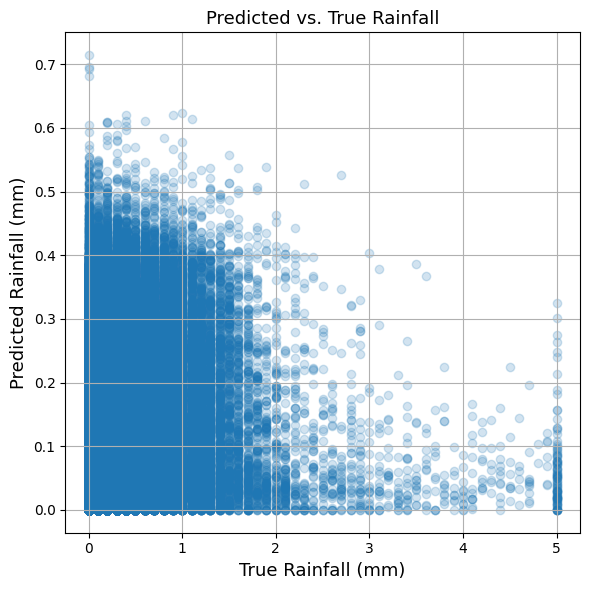

In [16]:
import matplotlib.pyplot as plt

y_pred_flat_clip = np.clip(y_pred_flat, 0, 5)
y_true_flat_clip = np.clip(y_true_flat, 0, 5)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat_clip, y_pred_flat_clip, alpha=0.2)
plt.xlabel("True Rainfall (mm)", fontsize=13)
plt.ylabel("Predicted Rainfall (mm)", fontsize=13)
plt.title("Predicted vs. True Rainfall", fontsize=13)
plt.grid(True)
plt.tight_layout()
#plt.savefig('../report/figures/model_summary/scatter_pred_true.pdf')
plt.show()

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step


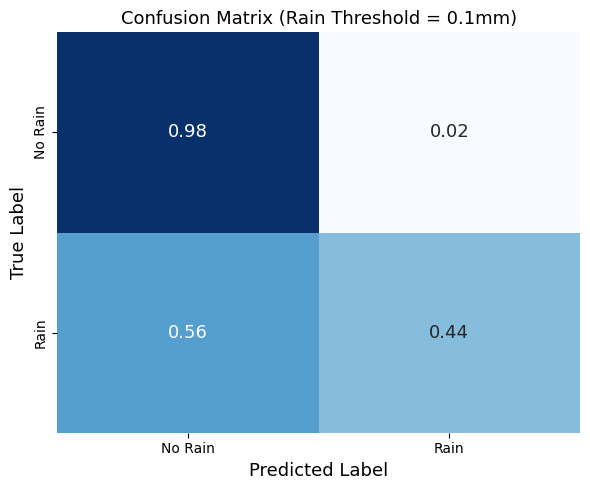

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume predictions are clipped/log-corrected
y_true_rain = np.expm1(y_test).flatten()
y_pred_rain = np.expm1(model_onestep.predict(x_test)).flatten()
y_pred_rain = np.clip(y_pred_rain, 0, None)

# Binarize: 1 = rain, 0 = no rain
threshold = 0.1
y_true_bin = (y_true_rain > threshold).astype(int)
y_pred_bin = (y_pred_rain > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='true')

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=["No Rain", "Rain"],
            yticklabels=["No Rain", "Rain"],
            annot_kws={"fontsize": 13})
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Confusion Matrix (Rain Threshold = 0.1mm)", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/confusion_matrix_thres.pdf')
plt.show()

In [ ]:
np.percentile(y_train, np.arange(101))


And we visualize some forecasts

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step


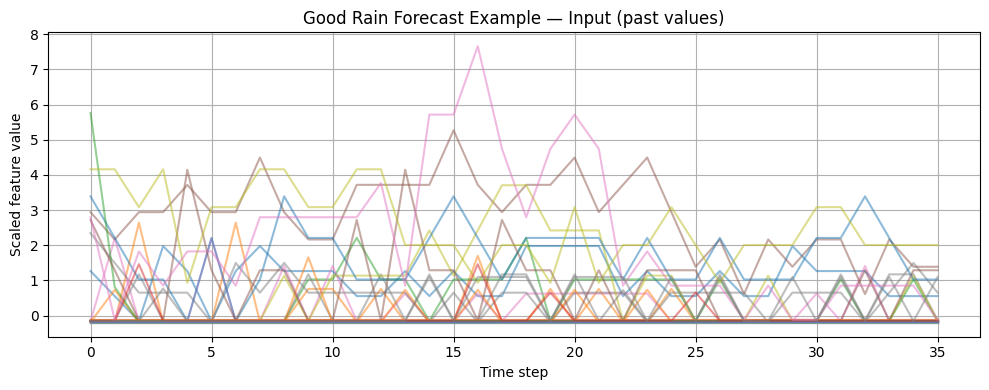

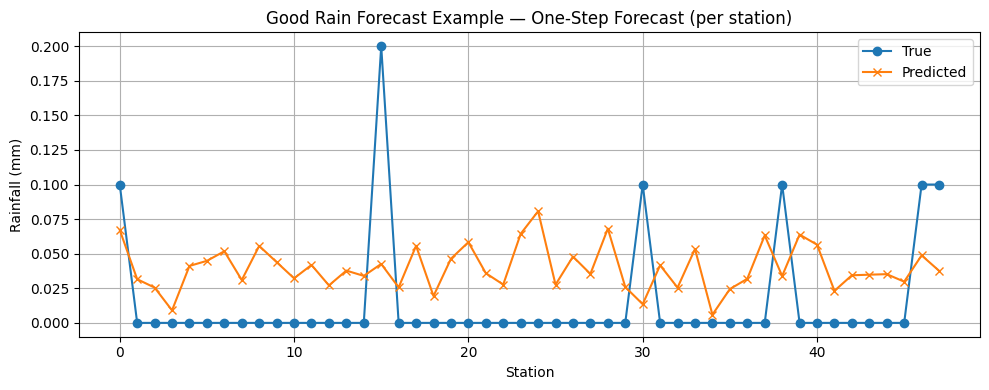

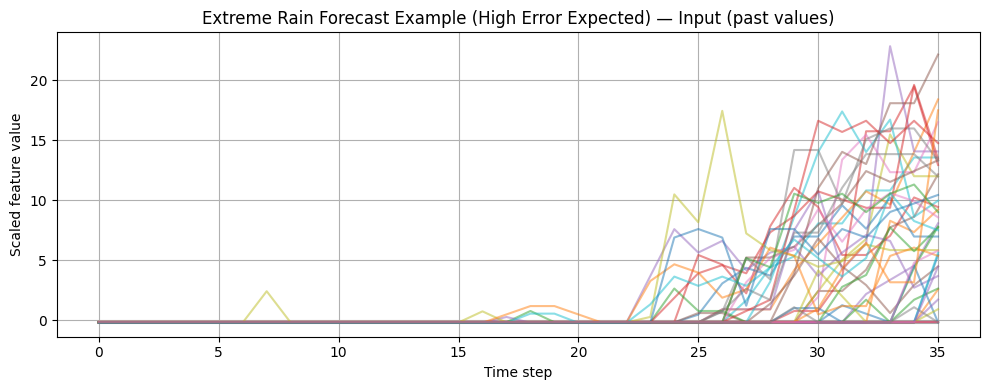

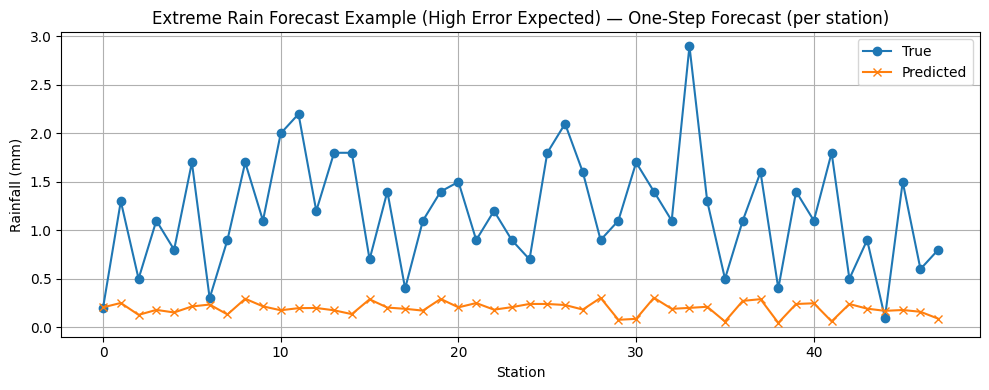

In [10]:
import random

# Re-log targets for easier work
y_true_full = np.expm1(y_test)
y_pred_full = np.expm1(model_onestep.predict(x_test))

# Get 6-hour totals per prediction (row-wise sum over stations)
total_rain_6hr = np.sum(y_true_full, axis=1)

# 1. Well-forecasted rainy sample (true > 0 and small error)
rainy_idxs = np.where(total_rain_6hr > 0)[0]
well_predicted = [i for i in rainy_idxs if np.allclose(y_true_full[i], y_pred_full[i], atol=1.0)]
idx_good = random.choice(well_predicted)

# 2. Extreme rain sample (top 10 max total rain)
idx_extreme = np.argsort(total_rain_6hr)[-10:]
idx_bad = idx_extreme[-1]

def plot_sample(idx, title):
    plt.figure(figsize=(10, 4))
    for station in range(y_true.shape[1]):
        plt.plot(x_test[idx, :, station], label=f"Station {station}", alpha=0.5)
    plt.title(f"{title} — Input (past values)")
    plt.xlabel("Time step")
    plt.ylabel("Scaled feature value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(y_true_full[idx], label="True", marker='o')
    plt.plot(y_pred_full[idx], label="Predicted", marker='x')
    plt.title(f"{title} — One-Step Forecast (per station)")
    plt.xlabel("Station")
    plt.ylabel("Rainfall (mm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot both
plot_sample(idx_good, "Good Rain Forecast Example")
plot_sample(idx_bad, "Extreme Rain Forecast Example (High Error Expected)")
